## Setup

In [3]:
!pip install duckdb -q

In [4]:
import torch
from torch import tensor
import torch.nn as nn
import duckdb
import pandas as pd

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device.type = }')

device.type = 'cuda'


### Dataset

In [13]:
con = duckdb.connect('choon_dataset.db')

con.sql('SHOW TABLES')

┌──────────────────┐
│       name       │
│     varchar      │
├──────────────────┤
│ choon_images     │
│ not_choon_images │
└──────────────────┘

In [14]:
choon_df = (
    con.sql('FROM choon_images').df()
    .assign(label=1)
)
not_choon_df = (
    con.sql('FROM not_choon_images').df()
    .assign(label=0)
)

all_df = (
    pd.concat([choon_df, not_choon_df])
    .reset_index(drop=True)
)

con.close()

all_df.head()

,image_tensors,label
0,"[0.7764706, 0.78039217, 0.78039217, 0.78039217...",1
1,"[0.7764706, 0.78039217, 0.76862746, 0.7647059,...",1
2,"[0.73333335, 0.74509805, 0.7529412, 0.7372549,...",1
3,"[0.83137256, 0.8392157, 0.84313726, 0.8352941,...",1
4,"[0.85490197, 0.8509804, 0.8509804, 0.8509804, ...",1


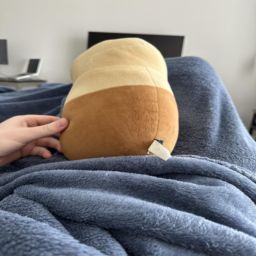

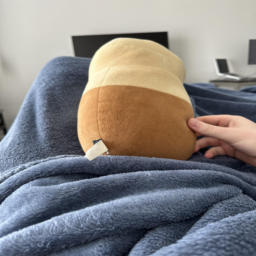

In [138]:
from torchvision import transforms
import numpy as np

def display_tensor_as_image(tensor: Tensor):
    '''
    Display a tensor of shape (196608) as a (3, 256, 256) image.
    '''
    tensor = tensor.view(3, 256, 256)

    to_img = transforms.ToPILImage()
    img: Image.Image = to_img(tensor)

    display(img)

display_tensor_as_image(tensor(all_df.iloc[0]['image_tensors']))
# display_tensor_as_image(tensor(np.flip(all_df.iloc[0]['image_tensors'].reshape(3, 256, 256))))

# display_tensor_as_image(tensor(all_df.iloc[0]['image_tensors'].reshape(3, 256, 256), axis=2).reshape(-1).copy())
display_tensor_as_image(tensor(np.flip(all_df.iloc[0]['image_tensors'].reshape(3, 256, 256), axis=2).reshape(-1).copy()))

In [15]:
all_shuffled = all_df.sample(frac=1, random_state=3).reset_index(drop=True)

train_frac = 0.7  # 70% for training
test_frac = 0.15  # 15% for testing
validate_frac = 0.15  # 15% for validation

total_len = len(all_shuffled)
train_len = int(total_len * train_frac)
test_len = int(total_len * test_frac)
validate_len = total_len - train_len - test_len

train_df = all_shuffled[:train_len]
test_df = all_shuffled[train_len:train_len+test_len]
validate_df = all_shuffled[train_len+test_len:]

dfs = {
    'train': train_df,
    'validate': validate_df,
    'test': test_df
}

for name, df in dfs.items():
    percentages = df.label.value_counts() / len(df)
    percentages = round(percentages, 2)
    percent_0, percent_1 = percentages[0], percentages[1]
    print(f"{name}")
    print(f'\tlen =   {len(df)}')
    print(f"\t% 0's = {percent_0}\n\t% 1's = {percent_1}")

train
	len =   272
	% 0's = 0.54
	% 1's = 0.46
validate
	len =   59
	% 0's = 0.47
	% 1's = 0.53
test
	len =   58
	% 0's = 0.57
	% 1's = 0.43


In [16]:
from torch.utils.data import DataLoader, Dataset

class ChoonDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = tensor(row['image_tensors']).view(3, 256, 256)
        label = tensor(float(row['label']))
        return (image, label)

In [92]:
train = ChoonDataset(train_df)
validate = ChoonDataset(validate_df)
test = ChoonDataset(test_df)

print(f'{len(train) = }, {len(validate) = }, {len(test) = }\n', sep='\n')
print(train[0], validate[0], test[0], sep='\n')

train_loader = DataLoader(train, batch_size=32, shuffle=True)
validate_loader = DataLoader(validate, batch_size=64)
test_loader = DataLoader(test, batch_size=64)

len(train) = 272, len(validate) = 59, len(test) = 58

(tensor([[[0.7255, 0.7137, 0.7098,  ..., 0.7137, 0.7961, 0.8118],
         [0.7216, 0.7059, 0.6941,  ..., 0.6902, 0.7647, 0.7176],
         [0.7176, 0.7020, 0.6863,  ..., 0.6118, 0.6980, 0.6745],
         ...,
         [0.1451, 0.3333, 0.4588,  ..., 0.0784, 0.0588, 0.0706],
         [0.1373, 0.3333, 0.3765,  ..., 0.0902, 0.0863, 0.0706],
         [0.1137, 0.3451, 0.3569,  ..., 0.0510, 0.0784, 0.0980]],

        [[0.7922, 0.7843, 0.7843,  ..., 0.7412, 0.8549, 0.8627],
         [0.7882, 0.7765, 0.7686,  ..., 0.7137, 0.8196, 0.7765],
         [0.7882, 0.7765, 0.7608,  ..., 0.6314, 0.7412, 0.7294],
         ...,
         [0.1412, 0.3255, 0.4392,  ..., 0.1137, 0.0941, 0.0941],
         [0.1373, 0.3216, 0.3647,  ..., 0.1216, 0.1216, 0.0941],
         [0.1137, 0.3373, 0.3451,  ..., 0.0863, 0.1137, 0.1216]],

        [[0.8627, 0.8510, 0.8510,  ..., 0.7137, 0.8235, 0.8275],
         [0.8588, 0.8431, 0.8353,  ..., 0.6941, 0.7922, 0.7490],
   

### Model Setup

In [112]:
from torchvision import models

def make_model() -> nn.Module:
    model = models.resnet18(weights='DEFAULT')

    # freeze initial layers, except for layer4
    for name, param in model.named_parameters():
        # if 'layer4' not in name:
        param.requires_grad = False

    # add custom head
    pretrained_in = model.fc.in_features
    custom_head = nn.Linear(pretrained_in, 1)
    model.fc = custom_head
    return model

make_model()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training

In [113]:
from typing import Callable
from dataclasses import dataclass
from torch import Tensor

def validate_one_epoch(model: nn.Module, validation_dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor]) -> tuple[float, float]:
    '''return the loss and the accuracy of the model on the validation dataloader'''
    model.eval()

    epoch_running_loss = 0
    total_samples = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.unsqueeze(-1).to(device)

            logits = model(inputs)

            # calculate loss
            loss = loss_fn(logits, labels)
            epoch_running_loss += loss.item()

            # caluclate accuracy
            predictions = (logits > 0).float() # convert to binary prediction
            correct += (predictions == labels).sum().item()
            total_samples += len(inputs)

    epoch_avg_loss = epoch_running_loss / len(validation_dataloader)
    accuracy = correct / total_samples
    
    return epoch_avg_loss, accuracy


def train_one_epoch(model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> float:
    '''train the model for one epoch. return the average loss of the epoch'''
    model.train()

    epoch_running_loss = 0

    for batch in dataloader:
        inputs, labels = batch

        inputs = inputs.to(device) #  move to GPU if available
        labels = labels.unsqueeze(-1).to(device) #  move to GPU if available

        optimizer.zero_grad() # zero gradients

        predictions = model(inputs)

        # compute loss and propogate gradients
        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        # update metainformation
        epoch_running_loss += loss.item()

    epoch_avg_loss = epoch_running_loss / len(dataloader)
    return epoch_avg_loss


@dataclass
class TrainingRunInfo():
    avg_training_losses: list[float]
    avg_validation_losses: list[float]
    validation_accuracies: list[float]

def train_n_epochs(
    n: int,
    model: nn.Module,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    loss_fn: Callable[[Tensor, Tensor], Tensor],
    optimizer: torch.optim.Optimizer
    ) -> TrainingRunInfo:

    avg_training_losses = []
    avg_validation_losses = []
    validation_accuracies = []

    for i in range(n):
        epoch_train_avg_loss = train_one_epoch(model, train_dataloader, loss_fn, optimizer)
        epoch_validation_avg_loss, epoch_validation_accuracy = validate_one_epoch(model, validation_dataloader, loss_fn)

        avg_training_losses.append(epoch_train_avg_loss)
        avg_validation_losses.append(epoch_validation_avg_loss)
        validation_accuracies.append(epoch_validation_accuracy)

        print(f'EPOCH {i}:') 
        print(f'train - epoch avg loss: {epoch_train_avg_loss}')
        print(f'valid - epoch avg loss: {epoch_validation_avg_loss}')

    return TrainingRunInfo(avg_training_losses, avg_validation_losses, validation_accuracies)

In [117]:
model = make_model()
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(lr=.001, params=model.parameters())

In [118]:
training_run_info = train_n_epochs(25, model, train_loader, validate_loader, loss_fn, optimizer)

EPOCH 0:
train - epoch avg loss: 0.6687474383248223
valid - epoch avg loss: 0.6026062369346619
EPOCH 1:
train - epoch avg loss: 0.5702225102318658
valid - epoch avg loss: 0.5488215088844299
EPOCH 2:
train - epoch avg loss: 0.5025728278689914
valid - epoch avg loss: 0.5245934724807739
EPOCH 3:
train - epoch avg loss: 0.46326284607251483
valid - epoch avg loss: 0.4701361358165741
EPOCH 4:
train - epoch avg loss: 0.4083585308657752
valid - epoch avg loss: 0.43693283200263977
EPOCH 5:
train - epoch avg loss: 0.3702530297968123
valid - epoch avg loss: 0.41973820328712463
EPOCH 6:
train - epoch avg loss: 0.35332709219720626
valid - epoch avg loss: 0.39310723543167114
EPOCH 7:
train - epoch avg loss: 0.3130747841464149
valid - epoch avg loss: 0.3843417763710022
EPOCH 8:
train - epoch avg loss: 0.30656498339441085
valid - epoch avg loss: 0.36132439970970154
EPOCH 9:
train - epoch avg loss: 0.29188986619313556
valid - epoch avg loss: 0.3511589467525482
EPOCH 10:
train - epoch avg loss: 0.286731

In [119]:
training_run_info.validation_accuracies

[0.6949152542372882,
 0.6949152542372882,
 0.7457627118644068,
 0.864406779661017,
 0.864406779661017,
 0.847457627118644,
 0.8813559322033898,
 0.8983050847457628,
 0.9152542372881356,
 0.8813559322033898,
 0.8983050847457628,
 0.9152542372881356,
 0.8983050847457628,
 0.9322033898305084,
 0.9152542372881356,
 0.8983050847457628,
 0.9322033898305084,
 0.9152542372881356,
 0.8983050847457628,
 0.9322033898305084,
 0.9322033898305084,
 0.9322033898305084,
 0.9322033898305084,
 0.9322033898305084,
 0.9322033898305084]

## Testing

In [139]:
model.eval()

epoch_running_loss = 0
total_samples = 0
correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.unsqueeze(-1).to(device)

        logits = model(inputs)

        # caluclate accuracy
        predictions = (logits > 0).float() # convert to binary prediction
        correct += (predictions == labels).sum().item()
        total_samples += len(inputs)

accuracy = correct / total_samples

print(accuracy)

0.8793103448275862
